In [ ]:
def readInput() -> str:
    # Open the file in read mode
    file = open("Input.txt", "r")
    content = file.read()
    return content

def getIDs(director, people) -> str: # returns all people under that name
    return people.loc[people['primaryName'] == director, 'nconst']

def getFilmIDs(directorID, crew):
    return crew.loc[crew['directors'].str.contains(directorID, na=False), 'tconst'].values

def isolateID(possibilities, people, ratings, crew) -> str:# returns most significant of list, as measured by number of ratings on first of knownForTitles.
    maxRatings = 0
    mostSignificant = ""
    for directorID in possibilities:
        significantFilmIDs = people.loc[people['nconst'] == directorID, 'knownForTitles'].values # gets director's best known titles
        significantFilmID = significantFilmIDs[0].split(',')[0] # gets first title from comma-seperated string
        rating = ratings.loc[ratings['tconst'] == significantFilmID, 'numVotes'].values # get film's votes
        if rating.size > 0:  # Ensure that we found a valid rating for the film
                rating_value = rating[0]  # Extract the scalar value from the pandas Series
                if rating_value > maxRatings:
                    maxRatings = rating_value
                    mostSignificant = significantFilmID
    mostSigDirector = crew.loc[crew['tconst'] == mostSignificant, 'directors'].values
    return mostSigDirector[0]

def processFilms(IDs, films):
    IDs = films.loc[(films['tconst'].isin(IDs)) & (films['titleType'] == 'movie'), 'tconst'].tolist()
    IDs = films.loc[(films['tconst'].isin(IDs)) & (films['startYear'] != '\\N'), 'tconst'].tolist()
    IDs = sorted(IDs, key=lambda filmID: films.loc[films['tconst'] == filmID, 'startYear'].values[0])
    return IDs

def introduce(ID, name, people):
    details = people.loc[people['nconst'] == ID].values
    birthYear = details[0][2]
    deathYear = details[0][3]
    professions = details[0][4].replace(',', '/')
    if deathYear == "\\N":
        print(f'{name}, is a {professions} born in {birthYear}')
    else:
        print(f'{name} ({birthYear} - {deathYear}), was a {professions}.')
    
def addShowcaseText(filmID, index, films, ratings, array):
    filmDetails = films.loc[films['tconst'] == filmID].values
    name = filmDetails[0][2]
    year = filmDetails[0][5]
    
    ratingDetails = ratings.loc[ratings['tconst'] == filmID]
    if ratingDetails.empty:
        array.append(f'\n{index+1}: {name} ({year}). \nThere are no ratings for {name}.')
        return
    averageRating = ratingDetails.iloc[0]['averageRating']
    numRatings = ratingDetails.iloc[0]['numVotes']
    
    array.append(f'\n{index+1}: {name} ({year}) has an average rating of \n{averageRating} over {numRatings} ratings.')
    
def addShowcaseImage(filmID, films, array):
    from matplotlib import pyplot as plt
    from matplotlib import image as mpimg
    
    filmDetails = films.loc[films['tconst'] == filmID].values
    name = filmDetails[0][2]
    year = filmDetails[0][5]
    
    from pathlib import Path
    from PIL import Image
    
    file = Path(f'Images\\{name}')
    
    search = f'{name} ({year}) movie poster'
    from icrawler.builtin import GoogleImageCrawler
    google_Crawler = GoogleImageCrawler(storage = {'root_dir': file})
    google_Crawler.crawl(keyword = search, max_num = 1)
    
    file = Path(f'{file}\\000001.jpg')
        
    if file.is_file(): # checks if image was correctly downloaded
        image = mpimg.imread(file)
    else:
        image = Image.new('RGB', (100, 100), color='white')  # Blank image
    array.append(image)
    
def clearSpace():
    from IPython.display import clear_output
    clear_output(wait=True)
    
def output(sets):
    import matplotlib.pyplot as plt
    import numpy as np

    n_sets = len(sets)
    ncols = 2
    nrows = (n_sets + ncols - 1) // ncols  # This ensures enough rows for all sets
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 7))
    axes = axes.flatten()

    for i, (image_data, text) in enumerate(sets): # Loop over the sets to plot images and text
        ax = axes[i] 
        ax.imshow(image_data, cmap='gray')
        ax.axis('off')  
        ax.text(0.5, -0.1, text, ha='center', va='center', transform=ax.transAxes)  # Add text below the image

    for j in range(n_sets, len(axes)): # Hide any unused axes (if there are any empty subplot spaces)
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def removeFiles():
    import shutil
    shutil.rmtree('Images')

def wait(sec):
    import time
    time.sleep(sec)

In [45]:
import pandas as pd

def summeriseRuntime(filmIDs, films):
    films['runtimeMinutes'] = pd.to_numeric(films['runtimeMinutes'], errors='coerce') # convert runtime field to numeric
    
    runtimes = []
    names = []
    for filmID in filmIDs: #loop through films
        filmDetails = films.loc[films['tconst'] == filmID].values
        name = filmDetails[0][2]
        runtime = filmDetails[0][7]
        runtimes.append(runtime)
        names.append(name)
    plotGraph(names, runtimes, 'Runtime over Films', 'Film', 'Runtime (minutes)')

def summerisePopularity(filmIDs, films, ratings):
    ratings['numVotes'] = pd.to_numeric(ratings['numVotes'], errors='coerce') # convert numVotes field to numeric
    votes = []
    names = []
    for filmID in filmIDs: #loop through films
        filmDetails = films.loc[films['tconst'] == filmID].values
        ratingDetails = ratings.loc[ratings['tconst'] == filmID].values
        name = filmDetails[0][2]
        if ratingDetails.any():
            numberOfVotes = ratingDetails[0][2]
            votes.append(numberOfVotes)
        else : continue
        names.append(name)
    plotGraph(names, votes, 'Popularity over Films', 'Film', 'Popularity (no. of votes)')

def summeriseRatings(filmIDs, films, ratings):
    ratings['averageRating'] = pd.to_numeric(ratings['averageRating'], errors='coerce') # convert numVotes field to numeric
    averages = []
    names = []
    for filmID in filmIDs: #loop through films
        filmDetails = films.loc[films['tconst'] == filmID].values
        ratingDetails = ratings.loc[ratings['tconst'] == filmID].values
        name = filmDetails[0][2]
        if ratingDetails.any():
            average = ratingDetails[0][1]
            averages.append(average)
        else : continue
        names.append(name)
    plotGraph(names, averages, 'Ratings over Films', 'Film', 'Average Rating')
    

def plotGraph(x, y, title, xLabel, yLabel):
    import matplotlib.pyplot as plt
    # Plotting the chart
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b')

    # Adding titles and labels
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

    # Displaying the chart
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
        

Christopher Nolan, is a writer/producer/director born in 1970


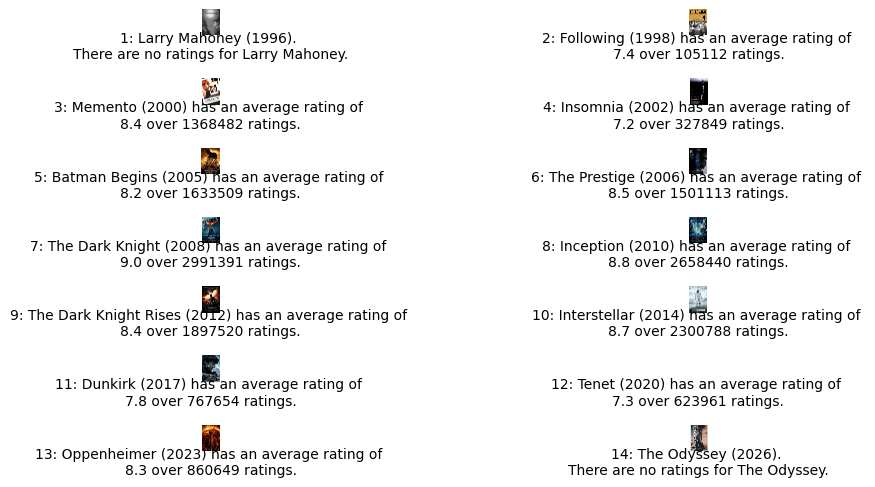

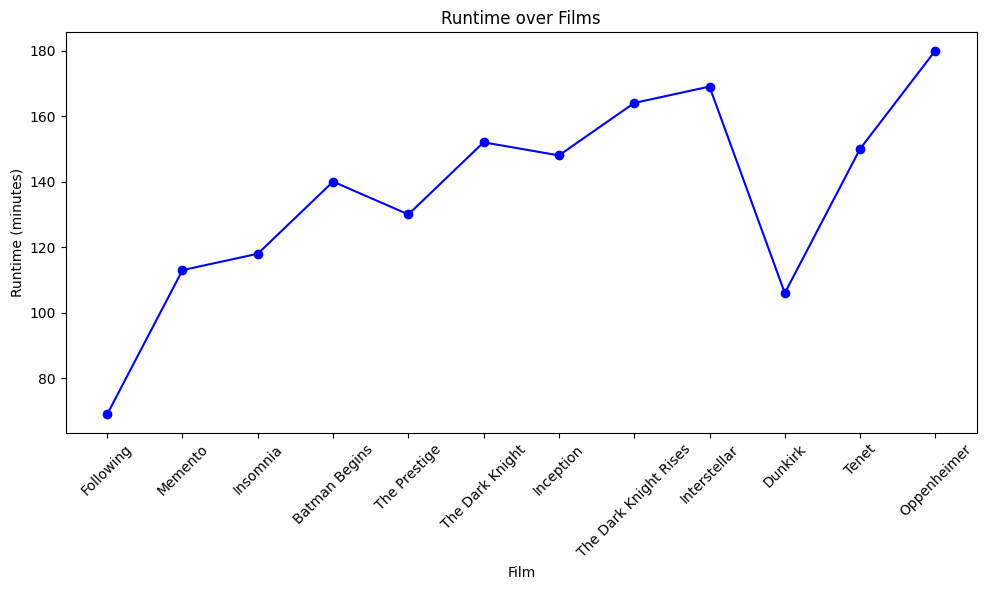

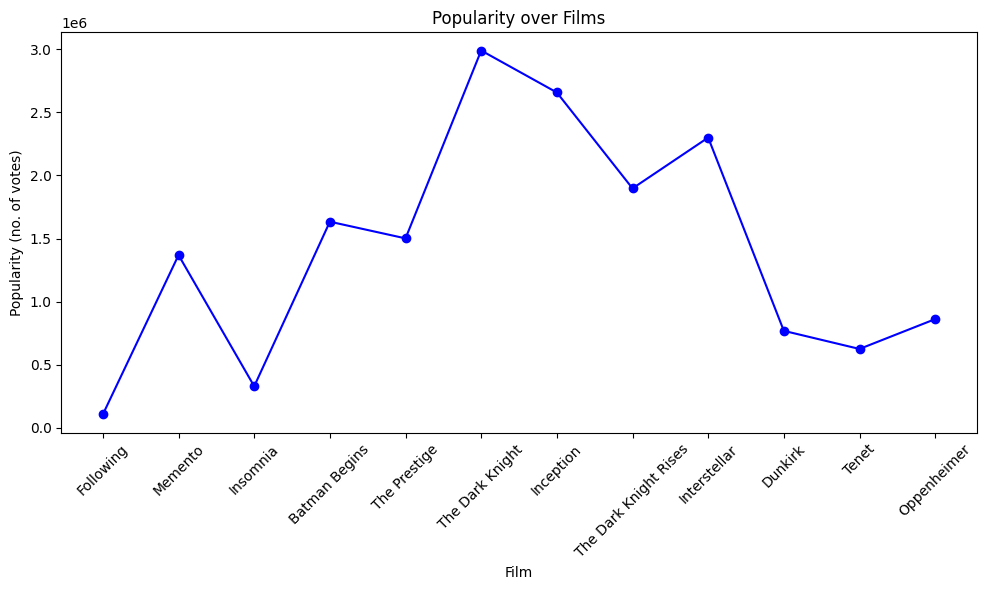

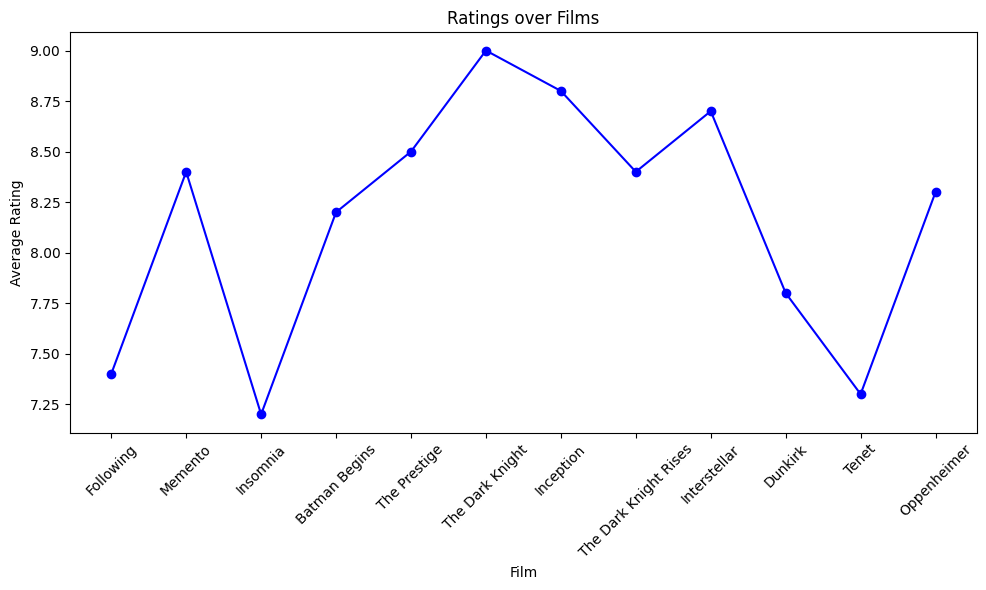

In [46]:
import pandas as pd

dfPeople = pd.read_csv(r'Example Data\name.basics.tsv', sep='\t')
dfRatings = pd.read_csv(r'Example Data\title.ratings.tsv', sep='\t')
dfCrew = pd.read_csv(r'Example Data\title.crew.tsv', sep='\t')
dfFilm = pd.read_csv(r'Example Data\title.basics.tsv', sep='\t')

directorName = readInput()
possibleDirectorID = getIDs(directorName, dfPeople)
directorID = isolateID(possibleDirectorID, dfPeople, dfRatings, dfCrew)

filmIDs = getFilmIDs(directorID, dfCrew)
filmIDs = processFilms(filmIDs, dfFilm)
showcasesText = []
showcaseImages = []

for i in range(len(filmIDs)):
    addShowcaseText(filmIDs[i], i, dfFilm, dfRatings, showcasesText)
    addShowcaseImage(filmIDs[i], dfFilm, showcaseImages)

wait(3)
clearSpace() # removes commands from image gathering

introduce(directorID, directorName, dfPeople)

sets = []
for i in range(len(showcasesText)):
    sets.append((showcaseImages[i], showcasesText[i]))

output(sets)
summeriseRuntime(filmIDs, dfFilm)
summerisePopularity(filmIDs, dfFilm, dfRatings)
summeriseRatings(filmIDs, dfFilm, dfRatings)
# removeFiles()